# Stochastic 2.6.1
#### General Agent-Based Bacteriophage Simulation
To be uploaded in support of Wedd et al 2024. Some functionalities not discussed in the paper have been removed.
Aaron Smith 2023.  
Design Informed by Michael Hunter 2022/23.  

#### Contents:
    0. Read This First
        - High Level Overview
        - Case Convention
    1. Import Statements and Colours
    2. Define Tau Distributions
    3. Define Beta Functions
    4. The 'Bacteria' Class
    5. The 'Bacteriophage_Population' Class
    6. Define Main Functions
    7. Simulation Parameters
    8. Run Simulation
    9. Data Analysis and Figure Plotting


## 0. Read This First

#### High Level Overview:
At the beginning of the simulation, a set of 'Bacteria' objects are created, along with a single 'Bacteriophage_Population' object for each species of infecting phage. Each 'Bacteria' object individually tracks how long it has left before duplication, or before lysis. There is no reference to any absolute time.  
At every timestep, the following happen:
- Bacteria Grow (according to specified function)
- Phage adsorb (according to specified function)
- Newly infected bacteria:
    - Choose a phage type (if infection is attempted by more than one phage species).
    - Determine a lysis time from distribution of tau.
- Currently infected bacteria check whether to lyse.
    - If so, produce new phage according to the system's beta function.
- Phage decay.
- Populations are recorded.

We seek to capture the behaviour of the model
$$ B  \stackrel{T}{\rightarrow} 2B $$
$$ B + V \stackrel{\alpha}{\rightarrow} I \stackrel{\tau}{\rightarrow} \beta V$$
$$ V  \stackrel{\delta}{\rightarrow} 0 $$
In which:  
$T$ denotes the doubling *time*. (Time to double is drawn from a distribution with mean $T$).  
$\alpha$ denotes the adsorbtion *rate*. (The number of adsorbtions has mean $\frac{\alpha(B+I)V\Delta t}{Vol}$), where $Vol$ is the volume being simulated 
$\tau$ denotes the lysis *time*. (Time to lysis is drawn from a distribution with mean $\tau$).  
$\beta$ denotes the burst size. (Burst is drawn either from a distribution with mean $\beta$, OR $\beta$ is calculated deterministically from some function of $\tau$).  
$\delta$ denotes the decay *rate*. (Number of phage to decay is drawn from a distribution with mean $\delta V \Delta t$).

#### Case Convention:
Rather than abstract variables, we use the full names wherever possible. For example functions are defined in terms of 'burst_size' rather than b.  
Custom functions and classes are always Captialised.  
Vairables inside functions are lower case, e.g. burst_size.  
Variables outside functions are upper case, e.g. Burst_Size.  
Class properties are lower case, e.g. Bacteriophage_Population.burst_size.

## 1. Import Statements and Colours

In [1]:
## Import Statements
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools as itl
from alive_progress import alive_bar
import sys

## Colours
Colour_Table = {"Bacteria Green" : "#19a926",
                "Bacteria Amber" : "#ffc90f",
                "Bacteria Red" : "#d63700",
                "Virus Blue" : "#15477a",
                "Virus Purple" : "#5f16ac",
                "Virus Pink" : "#d643c7"}

Bacteria_Colours = 3
Colour_List = list(Colour_Table.values())

In [2]:
## Slurm Array

# This section only needs to run if we are using the CSD3 cluster to conduct many runs in parallel. It does NOT need to be modified for differnet
# parameter values, but DOES need to be set up correctly at time of submitting sbtach. Uncomment every line below here:

# Means = [7.0, 8.7, 11, 14, 17, 21, 27, 33, 42]
# STDs = [1.0, 1.3, 1.6, 2.0, 2.5, 3.1, 3.9, 4.9, 6.1]
# BetaFunction = "Beta Normal"   # Allows us to change BetaFunction quickly from here

# LargeIndex = len(Means)    # How many different values of the mean?
# SmallIndex = len(STDs)    # How many different values of the STD?
# ArrayID = int(sys.argv[1])
# small = ArrayID % SmallIndex
# large = int((ArrayID - small) / SmallIndex)

# ExtMean = Means[large]
# ExtSTD = STDs[small]


## 2. Define Tau Distributions

Random number functions modified by introduction of a lower bound.

Normal / Gaussian PDF is defined by:
$$P_N(x) = \frac{1}{\sqrt{2\sigma^2\pi}}e^{\frac{-(x-\mu)^2}{2\sigma^2}}$$

Gamma PDF is defined by:
$$P_\gamma(x) = \frac{x^{k-1}e^{-x/\theta}}{\theta^k \Gamma(k)}$$

Where $\Gamma(k)$ is the Gamma Function, equivalent to $k!$ for positive integer $k$.
The Gamma distribution has mean $\mu = k\theta$, and variance $\sigma^2 = k\theta^2$.

In [3]:
## Truncated Gaussian

def Truncated_Gaussian(mean, std, lower_bound = 0, alpha = None):
    x = -1
    if lower_bound < 0:
        raise Exception("lower_bound must be greater than or equal to zero")
        return(0)
    else: 
        while x < lower_bound:
            x = np.random.normal(loc = mean, scale = std)
        return(x)

# Draws a random number from a Gaussian / Normal distribution. If that number is less than the specified lower bound, draws again (ad infinitum).
#     Note: lower_bound must be greater than or equal to zero.

In [4]:
## Truncated Gamma Distribution
# We wish to specify the mean and std of the distribution, rather than it's shape(k) and scale(theta).

def Truncated_Gamma(mean, std, lower_bound = 0, alpha = None):
    x = -1
    k = mean**2 / std**2
    theta = std**2 / mean
    if lower_bound < 0:
        raise Exception("lower_bound must be greater than or equal to zero")
        return(0)
    else: 
        while x < lower_bound:
            x = np.random.gamma(shape = k, scale = theta)
        return(x)

# Draws a random number from a Gamma distribution. If that number is less than the specified lower bound, draws again (ad infinitum).
#     Note: lower_bound must be greater than or equal to zero.

### 2.1 More Complex Distributions

#### Skew Normal Distribution

Generalisation of the Normal Distribution to allow non-zero skew.  
PDF given by

$$P(x, \mu, \sigma, a) = \frac{2}{\sigma}p_N\bigl(\frac{x - \mu}{\sigma}\bigr) \times c_N\bigl(a\frac{x - \mu}{\sigma}\bigr)$$

in which: $p_N$ is the Normal Distribution PDF for variable $x$, (or $\frac{x - \mu}{\sigma}$), and $c_N$ is the Normal Distribution CDF.  
Note that $a$, which can range from $-\infty$ to $+\infty$ is *not* the Skew, which ranges -1 to 1.  


This is made worse by the fact that the true sample mean and std do not match the nominal mean and std. If true mean is $M$ and true std is $\Sigma$, and we define $\delta = \frac{\alpha}{\sqrt{1 + \alpha^2}}$then:

$$M = \mu + \sigma\delta\sqrt{\frac{2}{\pi}}$$

$$\Sigma^2 = \sigma^2 \bigl( 1 - \frac{2\delta^2}{\pi} \bigr)$$

Inverting these to generate $\mu$, $\sigma$ from supplied true mean and std:

$$\sigma^2 = \Sigma^2 \bigl( 1 - \frac{2\delta^2}{\pi} \bigr)^{-1}$$

$$\mu = M - \sigma\delta\sqrt{\frac{2}{\pi}}$$

In [5]:
def Skew_Normal(mean, std, lower_bound = 0, alpha = 0):
    
    delta = alpha / (1 + alpha**2)**(0.5)
    sigma = (std**2 * (1 - (2*delta**2)/(np.pi))**(-1))**(0.5)
    mu = mean - sigma*delta*(2/np.pi)**(0.5)
    
    x = -1
    if lower_bound < 0:
        raise Exception("lower_bound must be greater than or equal to zero")
        return(0)
    else: 
        while x < lower_bound:
            x = sp.stats.skewnorm.rvs(size = 1, loc = mu, scale = sigma, a = alpha)[0]
        return(x)
    

In [6]:
## Distribution Lookup Table
# Allows appropriate direstibution to be called by corresponding string.

Distribution_Table = {"Truncated Gaussian" : Truncated_Gaussian,
                      "Truncated Gamma" : Truncated_Gamma,
                      "Skew Normal" : Skew_Normal}


## 3. Define Beta Functions

In this paper, we assume burst size to be normally distributed and independent of lysis time.

In [7]:
def Beta_Normal(tau, maturation_rate, eclipse_period, beta_mean, beta_std, beta_lower_bound):
    return (round(Truncated_Gaussian(beta_mean, beta_std, beta_lower_bound)))

## Lookup Table:
Beta_Table = {"Beta Normal" : Beta_Normal}

## 4. The 'Bacteria' Class

In [8]:
class Bacteria:
    def __init__(self, strain,
                 growth_function, doubling_time_mean, doubling_time_std, doubling_time_lower_bound,
                 maximum_adsorbed):
        
        # Type Properties
        self.strain = strain    # numerical species identifier
        self.infected = 0       # 0 if healthy, 1 if infected with phage 1 etc
        self.invaders = []      # list of phages currently attempting to invade the cell. [1,1,3] means 2 from type 1 and 1 from type 3.
        
        # Growth Properties
        self.growth_function = growth_function
        self.doubling_time_mean = doubling_time_mean
        self.doubling_time_std = doubling_time_std
        self.doubling_time_lower_bound = doubling_time_lower_bound
        
        # Infection / Defense Properties
        self.maximum_adsorbed = maximum_adsorbed
        
        # Countdowns - time to mitosis calculated at creation, time to lysis calculated on infection (countdown then ticks down, total does not).
        self.countdown_mitosis = Distribution_Table[growth_function](doubling_time_mean, doubling_time_std, doubling_time_lower_bound)
        self.total_mitosis = self.countdown_mitosis
        self.countdown_lysis = -1
        self.total_lysis = -1


## 5. The 'Bacteriophage_Population' Class

In [9]:
class Bacteriophage_Population:
    def __init__(self, initial_size, adsorption_rate, adsorption_limit, decay_rate, eclipse_period, maturation_rate,
                 beta_function, burst_size_mean, burst_size_std, burst_size_lower_bound,
                 tau_distribution, lysis_time_mean, lysis_time_std, lysis_time_lower_bound, lysis_time_alpha):
        
        # Population Properties
        self.size = initial_size
        
        # Life History Parameters
        self.adsorption_rate = adsorption_rate
        self.decay_rate = decay_rate
        self.adsorption_limit = adsorption_limit
        
        # Burst Size
        self.eclipse_period = eclipse_period
        self.maturation_rate = maturation_rate
        
        self.beta_function = beta_function    #string
        self.burst_size_mean = burst_size_mean
        self.burst_size_std = burst_size_std
        self.burst_size_lower_bound = burst_size_lower_bound
        
        # Lysis Time
        self.tau_distribution = tau_distribution    #string
        self.lysis_time_mean = lysis_time_mean
        self.lysis_time_std = lysis_time_std
        self.lysis_time_lower_bound = lysis_time_lower_bound
        self.lysis_time_alpha = lysis_time_alpha
        
## To Do: Would like to add whether or not phage allows superinfection.

# Steric Limit: Different phages bind to different receptors, but are also able to "get in each other's way". This diffuculty in adsorbing at
# high phage number is enforced in two ways:
# -Each bacteria has a maximum occupancy - a total number of phage that can adsorb to its surface. Adsorption attempts have a chance to fail based
#  on how close to maximum occupancy the cell is.
# -Each phage has its own individual adsorbtion limit. The number of phage of type j adsorbed to a cell can never exceed this limit.

## 6. Define Main Functions

High Level Overview:  
'Lock Targets' Function (called by Infect)  
Bacteria grow via 'Mitosis'  
Phages 'Infect(ion)' (select targets, and resovle any bacteria targeted by phages of more than 1 species)  
Phages 'Lys(is)' bacteria  
Phages 'Decay'  
'Sample' current population statistics
'Archive' at the end of the simulation to convert sampled data into a Pandas Data Frame

Our objects to operate on are:  
The set of sets of bacteria ("set_of_sets").  
The set of phage populations ("set_of_pools").  


In [10]:
def Scramble_Cell_Cycles(set_of_sets):
    for set_of_bacteria in set_of_sets:
        for cell in set_of_bacteria:
            if cell.infected == 0:
                cell.countdown_mitosis = cell.total_mitosis*np.random.rand()
    
    
    return(set_of_sets)

# This function causes each HEALTHY (infection == 0) cell to "forget" where in its cell cylce it is.
# i.e. it's current "countdown_mitosis" property is set to some random value between 0 and "total_mitosis".

In [11]:
def Scramble_Lysis_Cycles(set_of_sets):
    for set_of_bacteria in set_of_sets:
        for cell in set_of_bacteria:
            if cell.infected != 0:
                cell.countdown_lysis = cell.total_lysis*np.random.rand()
    
    
    return(set_of_sets)

# This function causes each INFECTED (infection != 0) cell to "forget" where in its lysis cylce it is.
# i.e. it's current "countdown_lysis" property is set to some random value between 0 and "total_lysis".

In [12]:
def Mitosis(set_of_sets, dt, logistic_correction = False, carrying_capacity = 0):
    
    # Count all bacteria if necessary:
    if logistic_correction == True:
        number_of_bacteria = 0
        for set_of_bacteria in set_of_sets:
            number_of_bacteria += len(set_of_bacteria)
            
        # Calculate logistic correction factor:
        LCF = 1 - number_of_bacteria / carrying_capacity
        
    
    # Begin Mitosis function proper
    for set_of_bacteria in set_of_sets:
        for mother in set_of_bacteria:
            
            # Advance Countdown
            if logistic_correction == False:
                mother.countdown_mitosis -= dt
            elif np.random.rand() < LCF:
                mother.countdown_mitosis -= dt
            
            
            # Mitosis if necessary
            if mother.countdown_mitosis <= 0 and mother.infected == 0:
                mother.countdown_mitosis += Distribution_Table[mother.growth_function](mother.doubling_time_mean, mother.doubling_time_std, mother.doubling_time_lower_bound)
                set_of_bacteria.append(Bacteria(mother.strain, mother.growth_function, mother.doubling_time_mean, mother.doubling_time_std, mother.doubling_time_lower_bound, mother.maximum_adsorbed))
            
    return(set_of_sets)


## To Do: Have a think about whether time should advance before or after the check?
# If logistic_correction is set to true, cells will slow their growth according to how close to the carrying capacity the total number of all cells is.
# They do this by rolling a number between 0 and 1, and if that number is less than (1 - B/C), not advancing their countdown.

In [13]:
def Adsorption(set_of_sets, set_of_pools, dt, Vol):
    
    ## Before starting, how many species of bacteria and phage are there?
    I = len(set_of_sets)
    J = len(set_of_pools)
    
    ## Each phage population calculates how many infections it should attempt for each bacterial species (poisson, mean = alpha V Bi dt / Vol)
    for (i,j) in itl.product(range(I), range(J)):
        
        number_of_adsorptions = np.random.poisson(set_of_pools[j].adsorption_rate * set_of_pools[j].size * len(set_of_sets[i]) * dt / Vol)
        np.clip(number_of_adsorptions, 0, set_of_pools[j].size)
        
        if number_of_adsorptions > 0:
            cells_targeted = np.random.randint(len(set_of_sets[i]), size = number_of_adsorptions)
        else:
            cells_targeted = []
    
        for target in cells_targeted:    # For each cell targeted...
            if np.random.rand() > (len(set_of_sets[i][target].invaders) / set_of_sets[i][target].maximum_adsorbed):  # If there is space to bind
                if set_of_sets[i][target].invaders.count(j+1) < set_of_pools[j].adsorption_limit:                    # And if the specific receptor sites have not been used up
                    if set_of_pools[j].size > 0:                                                                     # And if there are any phage left
                        (set_of_sets[i][target].invaders).append(j+1)                                            # Add phage to the list of invaders
                        set_of_pools[j].size -= 1                                                                # ... and remove it from the pool.
        
    
    return(set_of_sets, set_of_pools)


In [14]:
def Infection2(set_of_sets, set_of_pools, dt):
    
    # for every cell in all species:
    for i in range(len(set_of_sets)):
        for cell in set_of_sets[i]:
            
            # if the cell is healthy
            if cell.infected == 0 and len(cell.invaders) != 0:
            
                # roll a number for each invading phage
                high_roll = 0
                winning_phage = 0
                for entry in cell.invaders:
                    
                    ## Failure Rate, Defence etc goes here ##
                    
                    roll = np.random.rand()
                    if roll > high_roll:
                        high_roll = roll
                        winning_phage = entry
                
                # infection type changed to the highest rolling phage, lysis time calculated
                cell.infected = winning_phage
                cell.countdown_lysis = Distribution_Table[set_of_pools[winning_phage -1].tau_distribution](set_of_pools[winning_phage -1].lysis_time_mean,
                                                                                                           set_of_pools[winning_phage -1].lysis_time_std,
                                                                                                           set_of_pools[winning_phage -1].lysis_time_lower_bound,
                                                                                                           set_of_pools[winning_phage -1].lysis_time_alpha)
                cell.total_lysis = cell.countdown_lysis
            
    return(set_of_sets)

In [15]:
def Lysis(set_of_sets, set_of_pools, dt):
    
    for i in range(len(set_of_sets)):
        for j in reversed(range(0, len(set_of_sets[i]))):    # For all bacteria within all sets:
        
            if set_of_sets[i][j].infected != 0:
                set_of_sets[i][j].countdown_lysis -= dt    # Tick down clock
            
                if set_of_sets[i][j].countdown_lysis <= 0:
                    phage_index = set_of_sets[i][j].infected - 1 # +1 since ifection type 0 is healthy, infection type 1 is first phage et
                    set_of_pools[phage_index].size += Beta_Table[set_of_pools[phage_index].beta_function](set_of_sets[i][j].total_lysis,
                                                                                                      set_of_pools[phage_index].maturation_rate,
                                                                                                      set_of_pools[phage_index].eclipse_period,
                                                                                                      set_of_pools[phage_index].burst_size_mean,
                                                                                                      set_of_pools[phage_index].burst_size_std,
                                                                                                      set_of_pools[phage_index].burst_size_lower_bound)
            
                    del set_of_sets[i][j]   
         
    return(set_of_sets, set_of_pools)

In [16]:
def Decay(set_of_pools, dt):
    for phages in set_of_pools:
        mean_decay = phages.size * phages.decay_rate * dt
        number_decay = np.random.poisson(mean_decay)
        number_decay = np.clip(number_decay, 0, phages.size)
            
        phages.size -= number_decay
        
    return(set_of_pools)


In [17]:
def Bottleneck(set_of_sets, bac_factor, set_of_pools, phage_factor):
    
    if bac_factor > 1:
        raise Exception("Bacterial Bottleneck Factor must be less than or equal to 1")
    
    if bac_factor < 0 or phage_factor < 0:
        raise Exception("Both Bottleneck Factors must be greater than or equal to 0")
        
    # Bottleneck Bacteria
    for set_of_bacteria in set_of_sets:
        for j in reversed(range(0, len(set_of_bacteria))):
            roll = np.random.rand()
            if roll > bac_factor:
                del set_of_bacteria[j]
                
    # Bottleneck Phage
    for pool in set_of_pools:
        pool.size = round(phage_factor * pool.size)
    
    return(set_of_sets, set_of_pools)


# Bacterial and Phage populations are both multiplied by the respective factors.
# For phage this is easy, as the .size attribute is modified and rounded.
# For bacteria, each individual cell rolls to "decide" whether or not it is removed. This means the actual reduction is binomially distributed.




In [18]:
def Add_Bacteria(set_of_bacteria, number, strain, growth_function, doubling_time_mean, doubling_time_std, doubling_time_lower_bound, maximum_adsorbed):
                
    for i in range(number):
        set_of_bacteria.append(Bacteria(strain, growth_function, doubling_time_mean, doubling_time_std, doubling_time_lower_bound, maximum_adsorbed))
    
    return(set_of_bacteria)

## This function adds new bacteria to an existing set.

In [19]:
def Sample(set_of_sets, set_of_pools, sampling_data = []):
    
    new_data = []
    
    # Bacteria
    for bacteria_set in set_of_sets:
        count_all = [0]
        count_infected = list(np.zeros(len(set_of_pools) + 1))
        
        for cell in bacteria_set:
            count_all[0] += 1
            count_infected[cell.infected] += 1
            
        new_data.append(count_all + count_infected)
    
    
    # Phage Populations
    for pool in set_of_pools:
        new_data.append([pool.size])
    

    # Flatten
    new_data_flattened = []
    
    for sublist in new_data:
        new_data_flattened.extend(sublist)
    
    
    sampling_data.append(new_data_flattened)
    return(sampling_data)

# This function records population data and appends it to a provided list (of lists), or else creates a new one.
# Column order is: bacteria species 1 total, species 1 healthy, species 1 infected type 1 etc...
#                  species 2 total, healthy etc...
#                  phage pop 1 number, phage pop 2 number, etc...


In [20]:
def Archive(set_of_sets, set_of_pools, sampling_data):
    
    DF = pd.DataFrame(sampling_data)
    
    B = len(set_of_sets)    # Number of Bacterial Species.
    P = len(set_of_pools)    # Number of Phage Species and therefore bacterial infection variants per species.
    T = (P+2) * B + P    # Total number of columns
    
    # Create List for Column Headings
    headings = []
    for i in range(T):
        headings.append("%s"%(i))
    
    
    # Renaming Bacterial Columns
    for i in range(0, (P+2)*B, P+2):
        headings[i] = "Tot Bac %s"%(int(i/(P+2) + 1))
        headings[i+1] = "Bac %s Healthy"%(int(i/(P+2) + 1))
        for j in range(1, P+1):
            headings[i+1+j] = "Bac %s Infected %s"%(int(i/(P+2) + 1), j)
            
    # Renaming Phage Columns
    for j in range(0, P):
        headings[(P+2)*B + j] = "Bacteriophage %s"%(j+1)
    
    
    
    # Finally, apply headings to Data Frame
    DF.columns = headings
    
    return(DF)

# This function converts sampled data to a Pandas dataframe at the end of the simulation, so we can plot using column headings rather than list
# indices (which will change if we run the simulation with different numbers of bacterial and phage species.

The following fucntions are saved here for reference, but are no longer called in active running of the simulation.

In [21]:
def Lock_Targets(attempts_list):
    
    # Initialise
    target = 0
    spent_targets = []
    targets_list = []
    
    # Construct targelist to have same length as incoming attempts list
    for i in range(0, len(attempts_list)):
        targets_list.append(np.array([]))
    
    for i in range(0, len(attempts_list)):        # For every element, in every array in the attempts list...
        for j in range(0, len(attempts_list[i])):
            target = attempts_list[i][j]
            high_roll = 0
            winning_array = 0
            
            if target not in spent_targets:        # ...That hasn't been spoken for already...
                
                for k in range(0, len(attempts_list)):
                    for l in range(0, len(attempts_list[k])):
                        if attempts_list[k][l] == target:        # ...Check every element to see if they're the same...
                            
                            roll = np.random.random(1)        # ...if they are, roll a random number...
                            
                            if roll > high_roll:
                                high_roll = roll
                                winning_array = k        # ... and if that number if higher than any other, update which array is "winning".
                
                spent_targets.append(target)
                targets_list[winning_array] = np.append(targets_list[winning_array], target)
                
    return(targets_list)
    
# This function takes in a list of arrays, and outputs a list of arrays, but with duplicate values removed.
# Which array a value survives in is probabilistic, according to how many times it existed in each array at the outset.


In [22]:
def Infection(set_of_sets, set_of_pools, dt, print_targets = False):
    
    # Step 1 - Each phage population selects a number of targets, distributed randomly from across the available bacteria
    
    # 1.1 How many species are there?
    number_of_strains = len(set_of_sets)
    number_of_phage_pools = len(set_of_pools)
    
    # 1.2 How many bacteria are there?
    number_of_bacteria = 0    # total number of bacteria
    bac_populations = []      # list, showing number of bacteria in each set
    for set_of_bacteria in set_of_sets:
        number_of_bacteria += len(set_of_bacteria)
        bac_populations.append(len(set_of_bacteria))
        
    # 1.3 How many phages from each pool should attempt infection? (Poisson Dist, mean: alpha (B+I) V dt)
    attempts_list = []
    for phage_pool in set_of_pools:
        attempted_infections = np.random.poisson(phage_pool.adsorption_rate * phage_pool.size * number_of_bacteria * dt)  # Draw from possion
        attempted_infections = np.clip(attempted_infections, a_min = 0, a_max = phage_pool.size)  # Ensure this number does not exceed V
        attempts_list.append(attempted_infections)
        
        phage_pool.size -= attempted_infections  # Remove infecting phage from the pool
    
    
    # Step 2 -  Target specific bacteria
    
    # 2.1 Modify the attempts list, replacing each entry i (value ni) with ni random numbers between 0 and number_of_bacteria
    for i in range(len(attempts_list)):
        attempts_list[i] = np.random.randint(number_of_bacteria, size = int(attempts_list[i]))
        
    if print_targets == True:
        print("attempts list", attempts_list)
    
    
    # 2.2 Remove Overlap by calling the previously defined 'Lock Targets' function
    targets_list = Lock_Targets(attempts_list)
    del attempts_list    # to free memory
    
    if print_targets == True:
        print("targets list", targets_list)
    
    
    # 2.3 Bacteria currently numbered as a whole, we need to create targeting tuples.
    for i in range(0, len(targets_list)):
        targets_list[i] = list(targets_list[i])    # List of arrays now needs to be a list of lists to cope with tuples
        for j in range(0, len(targets_list[i])):
            target = targets_list[i][j]
            k = 0
            while target >= bac_populations[k]:
                target -= bac_populations[k]
                k += 1
            
            targets_list[i][j] = [k, target]    # targets_list is now a list of lists of tuples, like "bacterial coordinates".
                                                # targets_list [i][j][0] gives which bacteria species to infect
                                                # targets_list [i][j][1] gives which bacteria within that species to infect.
    
    
    # Step 3 - bacteria change infection status, and roll time to lysis.
    for i in range(0, len(targets_list)):
        for j in range(0, len(targets_list[i])):    # For each target (j) of each phage species (i)
            [k, target] = targets_list[i][j]
            k = int(k)
            target = int(target)
            
            if set_of_sets[k][target].infected == 0:
                set_of_sets[k][target].infected = i + 1 # +1 since ifection type 0 is healthy, infection type 1 is first phage etc
                set_of_sets[k][target].countdown_lysis = Distribution_Table[set_of_pools[i].tau_distribution](set_of_pools[i].lysis_time_mean,
                                                                                                          set_of_pools[i].lysis_time_std,
                                                                                                          set_of_pools[i].lysis_time_lower_bound,
                                                                                                          set_of_pools[i].lysis_time_alpha)
                set_of_sets[k][target].total_lysis = set_of_sets[k][target].countdown_lysis
    
    return(set_of_sets, set_of_pools)
    

## 7. Setup the Simulation

These blocks control the simulation parameters.

In [23]:
## Simulation Parameters ##

T = 300            # Maximum time (min)
dt = 0.01      # Timestep value (min)
NR = 1        # Number of repeats
Vol = 10**(-5)      # Volume of liquid culture to simulate (mL) (Experimental cultures reach approx 10^9 cells per mL, Overnights 10^10)
Carrying_Capacity = 100_000    # Maximum ecologically possible number of cells
Logistic_Correction = True    # If population exceeds carrying capacity, it will will NOT decay to reach it, but all cell growth will be halted
Victory_Threshold = 0.7    # Fraction of the phage population a single species must occupy to be declared "winner". 0.7 for a 5% advantage.
np.random.seed(1)


## Bacteria ##
Bacteria_1_Params = (1, "Truncated Gaussian", 20, 2.5, dt, 100)
Bacteria_1_Number = 10_000

# Bacteria_i_Params are: (strain, growth function, doubling time mean, std and lower bound, max adsorbed).


## Bacteriophage ##
Phage_1_Params = (100, 3*10**(-9), 100, 0.00013, 0, 0, "Beta Normal", 150, 50, 0, "Truncated Gaussian", 17, 2.5, dt, 0)
Phage_2_Params = (100, 3*10**(-9), 100, 0.00013, 0, 0, "Beta Normal", 150, 50, 0, "Truncated Gaussian", 17, 3.0, dt, 0)

# Phage_i_Params are: (initial size, adsorption rate, adsorption limit, decay rate, eclipse period, maturation rate,
#                      burst size function, mean, std, lower bound
#                      lysis time distribution, mean, std, lower bound, skew-alpha)


## Do Not Change ##

Nt = int(T/dt)     # Number of timesteps
t = 0            # Current time
N_squared = Nt*NR       # Total number of steps across all reps

## Write-to Data Sets ##

RepeatsData = []    # On completion of one run, RepeatsData is appeneded with the full dataset from that run
RepeatsBottles = []     # On completion of one run, RepeatsBottles is appeneded with the ticks (not times) at which bottlenecks occured
Winners = []    # If a run breaks early, this list is appended with the winning phage. If the run times out, it is appeneded "t".
BreakTimes = []    # If a run breaks early, list appended with the time. If the run times out, it is appeneded "t".


## 8. Run the Simulation

Runtime Log:
10,000 Cells, 100 Phage, 5 Repeats: 47% in 1 hour 19 min.

In [24]:
## Load a Master Progress Bar ##

with alive_bar(N_squared, force_tty = True) as bar:  # Load a progress bar for N_squared steps.

    for rep in range(NR):
    
        ## Running Simulation ##
    
        ### Initial ###
        # Load / Reset Bacteria
        Bacteria_1 = [Bacteria(*Bacteria_1_Params) for i in range(Bacteria_1_Number)]
        All_Bacteria = [Bacteria_1]    ## add ,Bacteria_2] if necessary
        All_Bacteria = Scramble_Cell_Cycles(All_Bacteria)
        
        # Load / Reset Phage
        Phage_1 = Bacteriophage_Population(*Phage_1_Params)
        Phage_2 = Bacteriophage_Population(*Phage_2_Params)
        # Phage_3 = Bacteriophage_Population(*Phage_3_Params)
        All_Phage = [Phage_1, Phage_2]
        
        # Initialise / Reset Datasets
        Dataset = []    # Population Data for this run only.
        Bottleneck_Ticks = []    # Bottleneck Times for this run only.
        Did_Simulation_Break = False
    
    
        ### During ###
        for tick in range(0, Nt):
            t = tick*dt
            
            # Core Biology
            All_Bacteria = Mitosis(All_Bacteria, dt, Logistic_Correction, Carrying_Capacity)
            All_Bacteria, All_Phage = Adsorption(All_Bacteria, All_Phage, dt, Vol)
            All_Bacteria = Infection2(All_Bacteria, All_Phage, dt)
            All_Bacteria, All_Phage = Lysis(All_Bacteria, All_Phage, dt)
            All_Phage = Decay(All_Phage, dt)
            
            # Check whether to apply Bottleneck
            if len(Bacteria_1) <= (Bacteria_1_Number)/100:
                All_Bacteria, All_Phage = Bottleneck(All_Bacteria, 0.001, All_Phage, 0.001)
                Bacteria_1 = Add_Bacteria(Bacteria_1, Bacteria_1_Number, *Bacteria_1_Params)
#                Bacteria_2 = Add_Bacteria(Bacteria_2, Bacteria_2_Number, *Bacteria_2_Params)
                All_Bacteria = Scramble_Cell_Cycles(All_Bacteria)
                Bottleneck_Ticks.append(tick)

                # Check whether to terminate the Simulation
                Total_Number_of_Phage = 0
                Biggest_Pool = 0
                Winning_Phage = 0
                
                for j in range(len(All_Phage)):
                    Total_Number_of_Phage += All_Phage[j].size
                    if All_Phage[j].size >= Biggest_Pool:
                        Biggest_Pool = All_Phage[j].size
                        Winning_Phage = j+1
                        
                if Biggest_Pool >= Victory_Threshold * Total_Number_of_Phage:
                    Winners.append(Winning_Phage)
                    Did_Simulation_Break = True
                    break # Breaks out of the innermost enclosing 'for' loop, in this case, iterating over 'tick'.
                

                        

            Dataset = Sample(All_Bacteria, All_Phage, Dataset)
            bar()
            
        
        ### After ###
        RepeatsData.append(Dataset)
        RepeatsBottles.append(Bottleneck_Ticks)
        
        if Did_Simulation_Break == False:
            Winners.append("t")
            BreakTimes.append("t")
            
        else:
            BreakTimes.append(t)

|████████████████▍⚠︎                      | (!) 12279/30000 [41%] in 2:44.4 (73.2▇▇▅ 6557/30000 [22%] in 1:25 (~5:04, 


In [25]:
## Display Dataframes ##

DFL = []    # Data Frame List, a list of Pandas Dataframes corresponding to each simulation run.
for Dataset in RepeatsData:
    DF = Archive(All_Bacteria, All_Phage, Dataset)
    display(DF)
    DFL.append(DF)
    # DF.to_csv("Single_Sim.csv")  # Record a single simulation for plotting elsewhere

    
## Out Data ##
print("Reps: ", NR)
print("Winners: ", Winners)
print("Break Times: ", BreakTimes)
print("Mean Lysis Times: ", Phage_1.lysis_time_mean, Phage_2.lysis_time_mean)
print("Lysis Time STD: ", Phage_1.lysis_time_std, Phage_2.lysis_time_std)
print("Beta Function: ", Phage_2.beta_function)

#DF = pd.DataFrame(Winners, BreakTimes)
#print(DF)
#DF.to_csv("OutData_{}_{}_{}_{}_{}.csv".format(Phage_2.lysis_time_mean, Phage_2.lysis_time_std, Phage_2.beta_function, T, NR))

,Tot Bac 1,Bac 1 Healthy,Bac 1 Infected 1,Bac 1 Infected 2,Bacteriophage 1,Bacteriophage 2
0,10003,9999.0,2.0,2.0,98,98
1,10009,9995.0,5.0,9.0,95,91
2,10014,9996.0,7.0,11.0,93,89
3,10018,9997.0,7.0,14.0,93,86
4,10027,10002.0,9.0,16.0,91,84
...,...,...,...,...,...,...
12274,104,0.0,22.0,82.0,330409,904080
12275,103,0.0,21.0,82.0,330640,904077
12276,103,0.0,21.0,82.0,330640,904076
12277,103,0.0,21.0,82.0,330640,904075


Reps:  1
Winners:  [2]
Break Times:  [122.79]
Mean Lysis Times:  17 17
Lysis Time STD:  2.5 3.0
Beta Function:  Beta Normal


## 9. Data Analysis and Figure Plotting

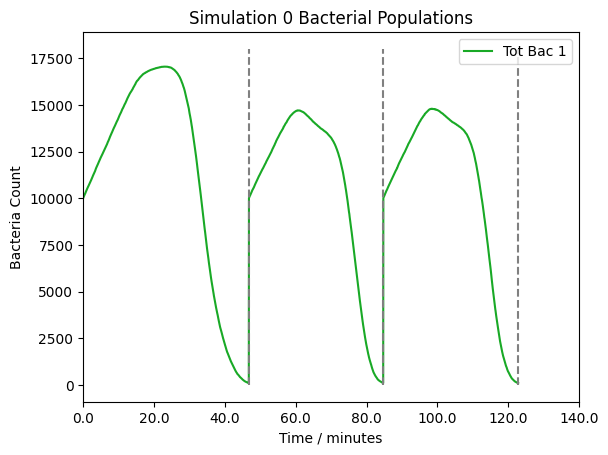

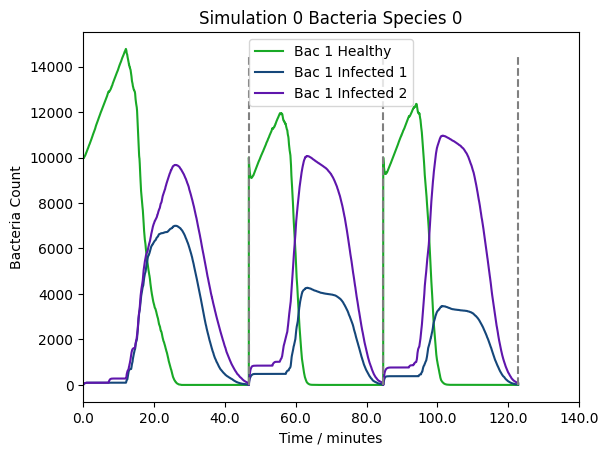

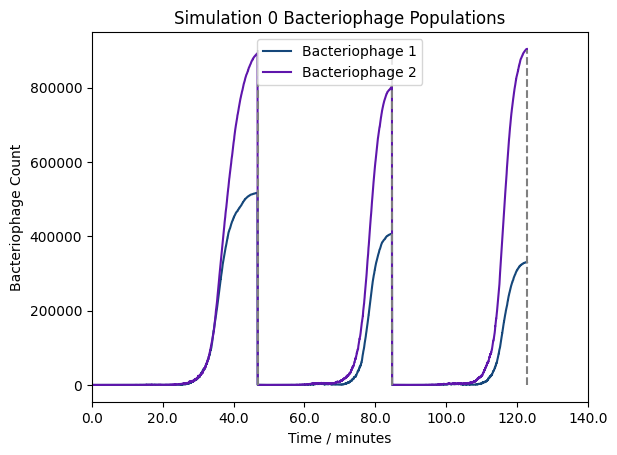

<Figure size 640x480 with 0 Axes>

In [26]:
## Population Line Graphs and Moving Average

# Moving Average Window:
Apply_Moving_Average = False
Window = 101    # MUST BE ODD!
Half_Window = int((Window - 1) / 2)


## For each dataframe...
for rep in range(len(DFL)):
    DF = DFL[rep]
    
    
    # Plot Bacterial Populations
    for i in range(len(All_Bacteria)):
        DF["Tot Bac %s"%(i+1)].plot(color = Colour_List[i])

    plt.legend()    
    plt.ylabel("Bacteria Count")
    plt.title("Simulation %s Bacterial Populations"%(rep))
    
    # Convert x axis to minutes
    plt.xlabel("Time / minutes")
    locs, labels = plt.xticks()
    labels = [float(item)*dt for item in locs]
    plt.xticks(locs, labels)
    plt.xlim(left = 0)


    # Dashed lines for bottlenecks:
    locs, labels = plt.yticks()
    height = 0.9*max(locs)
    plt.vlines(RepeatsBottles[rep], 0, height, color = "gray", linestyle = "dashed")
    
    plt.show()
    plt.clf()
    
    
    # Plot Bacterial Populations by Health (seperate figure for each)
    for i in range(len(All_Bacteria)):
        
        DF["Bac %s Healthy"%(i+1)].plot(color = Colour_List[i])
        
        for j in range(len(All_Phage)):
            DF["Bac %s Infected %s"%(i+1, j+1)].plot(color = Colour_List[Bacteria_Colours + j])
            
            
        plt.legend()    
        plt.ylabel("Bacteria Count")
        plt.title("Simulation %s Bacteria Species %s"%(rep, i))

        # Convert x axis to minutes
        plt.xlabel("Time / minutes")
        locs, labels = plt.xticks()
        labels = [float(item)*dt for item in locs]
        plt.xticks(locs, labels)
        plt.xlim(left = 0)

        # Dashed lines for bottlenecks:
        locs, labels = plt.yticks()
        height = 0.9*max(locs)
        plt.vlines(RepeatsBottles[rep], 0, height, color = "gray", linestyle = "dashed")

        plt.show()
        plt.clf()


    # Plot Phage Populations (linear)
    for i in range(len(All_Phage)):
        # Plot raw data
        Column = DF["Bacteriophage %s"%(i+1)]
        if Apply_Moving_Average == True:
            Column.plot(color = Colour_List[i+Bacteria_Colours], alpha = 0.4) # If we're averaging, fade out the data
        else:
            Column.plot(color = Colour_List[i+Bacteria_Colours], alpha = 1) # If we're not averaging, plot it normally
    
        if Apply_Moving_Average == True:
            # Calculate moving average (backwards-looking)
            Moving_Average = Column.rolling(Window, min_periods = 1).mean()

            # Convert to centred moving average
            for j in range(len(Moving_Average) - Half_Window):
                Moving_Average[j] = Moving_Average[j + Half_Window]

            # And drop the duplicate data from the end of the list       
            for j in range(len(Moving_Average) - Half_Window, len(Moving_Average)):
                del(Moving_Average[j])

            # Plot moving average
            Moving_Average.plot(color = Colour_List[i+Bacteria_Colours], alpha = 1, label = "Moving Average %s"%(i+1))

    plt.legend()
    plt.ylabel("Bacteriophage Count")
    plt.title("Simulation %s Bacteriophage Populations"%(rep))
    
    # Convert x axis to minutes
    plt.xlabel("Time / minutes")
    locs, labels = plt.xticks()
    labels = [float(item)*dt for item in locs]
    plt.xticks(locs, labels)
    plt.xlim(left = 0)

    # Dashed lines for bottlenecks:
    locs, labels = plt.yticks()
    height = 0.9*max(locs)
    plt.vlines(RepeatsBottles[rep], 0, height, color = "gray", linestyle = "dashed")
    
    plt.show()
    plt.clf()
    
